In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,recall_score,precision_score, fbeta_score
import xgboost as xgb
import nltk
from tabulate import tabulate
import os
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/simran.tyagi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
%run ./_preprocess.ipynb

#ds_root = '/home/gaurav.gupta/projects/PoCs/brandMention/brand_datasets/'
#r_path = os.path.join(ds_root, 'ds_complaints', 'panasonic_random_sample_predicted.csv')
#r_df = read_file(r_path)

#m_path = os.path.join(ds_root, 'ds_complaints', 'panasonic_v1_g.csv')
#m_df = read_file(m_path)

#raw_df = pd.concat([r_df, m_df])

#raw_df.reset_index(drop=True, inplace=True)
raw_df = pd.read_csv('/home/simran.tyagi/Downloads/panasonic_v1_f.csv')

options = {
    'handle_unicode': True,
    'handle_emoji': True,
    'handle_email': True,
    'handle_username': True,
    'handle_hashtags': True,
    'handle_url': True,
    'handle_markup': True,
    'handle_retweet': True,
    'handle_case': True,
    'handle_lemmatization': True,
    'handle_stopwords': True,
    'handle_punctuation': True,
    'handle_contractions': True,
    'print_stats': True
}
df = process_data(raw_df, **options)

# replace placeholders.
df.text = df.text.str.replace('HASHTAG', '', )
df.text = df.text.str.replace('HANDLE', '')
df.text = df.text.str.replace('URL', '')
df.text = df.text.str.replace('rt', '')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/simran.tyagi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


------------------  -----------  ------------
Step                Total words  Unique words
Start               77684        20298
Remove Retweet      66365        18469
Lower               66365        16577
Remove Retweet      66649        16528
Lemmatize           66649        15775
Unicode Fix         66656        15752
Replace emoji       67043        15848
Stop words          50235        15273
Email Replace       50235        15266
UserName replace    50921        14248
HashTags Replace    64615        10461
URL Replace         64615        8398
MARKUP Replace      64615        8397
Remove punctuation  64615        6668
------------------  -----------  ------------


In [23]:
df

,created_at,text,Complaint,Type,orig_text
0,2017-12-28 21:34:45+00:00,way skip play guide one page time tx50ex700b ...,0,None,Is there a way of skipping through the @Freevi...
1,2017-12-28 02:59:00+00:00,check new kxfa133 replacement film factory sea...,0,None,Check out New Panasonic KX-FA133 Replacement F...
2,2017-12-25 03:54:18+00:00,come let u adore ðÿž star ðÿž film nickolas al...,0,None,O Come Let us Adore Him ðŸŽ¶ â­ï¸ ðŸŽ„\n A F...
3,2017-12-24 20:07:23+00:00,sad hate company like much india head need ur...,0,None,So sad to hate a company I liked so much #Pana...
4,2017-12-18 05:43:26+00:00,horrible pathetic service ordered trimmer ge...,0,None,Horrible pathetic service from #Flipkart.Order...
...,...,...,...,...,...
3036,NaN,late daily canon shooter thanks,0,None,The latest The Daily Canon Shooter! https://t....
3037,NaN,listen news,0,None,Listen to @BT_India News #Podcast with @rashop...
3039,NaN,lumix tz60 silver 9999,0,None,#Panasonic Lumix TZ60 Silver £99.99 - #Chiches...
3042,NaN,nice pic grinning squinting face mt 20184 ...,0,None,Nice Pic! 😆 MT @sanchexsanche #HongKong\n2018....


In [11]:
from sklearn.metrics import plot_confusion_matrix
from collections import OrderedDict


def test_model(model):
    pred_test = model.predict(x_test)
    model_acc_score = accuracy_score(y_test, pred_test)
    model_f1_score = f1_score(y_test, pred_test)
    model_prec_score = precision_score(y_test, pred_test)
    model_recall_score = recall_score(y_test, pred_test)
    model_f2_score = fbeta_score(y_test, pred_test, beta=2)
    results = []
    results.append(('Metric',   'Score'))
    results.append(('Accuracy', model_acc_score*100))
    results.append(('F1 Score', model_f1_score*100))
    results.append(('F-Beta Score', model_f2_score*100))
    results.append(('Precision Score', model_prec_score*100))
    results.append(('Recall Score', model_recall_score*100))
    print(tabulate(results))
    return pred_test


def plot_important_features(clf, tfidf, axs):
    # Display Important feature
    n = 20
    f_imp = [list(i) for i in list(zip(clf.feature_importances_, tfidf.get_feature_names()))]
    f_imp_df = pd.DataFrame(f_imp, columns=['Importance', 'Feature'])
    top_n_features = f_imp_df.sort_values(by=['Importance'], ascending=False).head(n).sort_values(by=['Importance'])
    axs[1].barh(top_n_features['Feature'], top_n_features['Importance'])
    axs[1].set_title('MOST Important feature as per RF')
    return


(2421, 233)
[13:42:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
---------------  -----------------
Metric           Score
Accuracy         93.53507565337001
F1 Score         79.4759825327511
F-Beta Score     81.39534883720931
Precision Score  76.47058823529412
Recall Score     82.72727272727273
---------------  -----------------


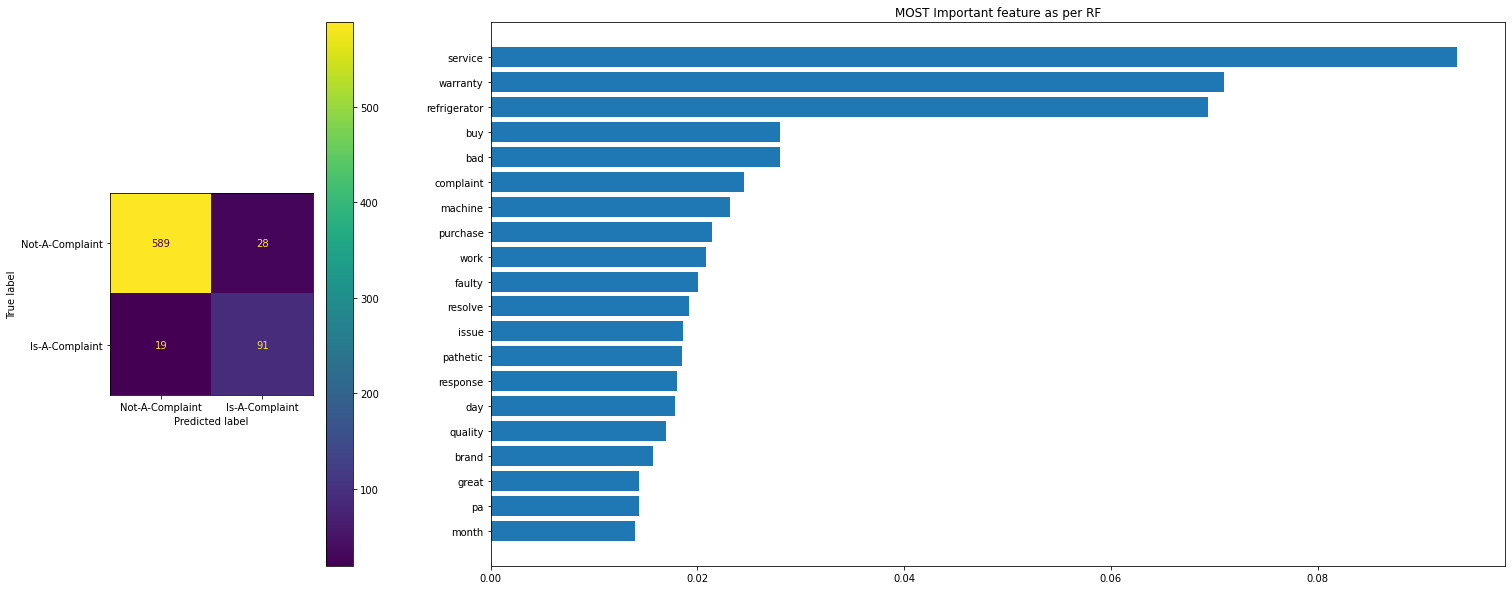

In [12]:

labelEncoder = OrderedDict({'Not-A-Complaint': 0, 'Is-A-Complaint': 1, })
display_labels = list(labelEncoder.keys())
labels = list(labelEncoder.values())


tfidf = TfidfVectorizer(lowercase=False, max_df=.8, min_df=0.01, ngram_range=(1,2))
vectors = tfidf.fit_transform(df['text']).toarray()
print(vectors.shape)
x_train, x_test, y_train, y_test = train_test_split(vectors, df['Complaint'], random_state=42, test_size=0.30)

model_x = xgb.XGBClassifier(use_label_encoder=False,
                            
                            learning_rate=0.40,
                            n_estimators=150, 
                            max_depth=4,  
                            subsample=0.8,  
                            min_child_weight=.9, 
                            reg_alpha=0.6,  
                            reg_lambda=0.3,
                            seed=42).fit(x_train, y_train)

pred_test = test_model(model_x)
fig, axs = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [1, 4]})
plot_confusion_matrix(model_x, x_test, y_test, labels=labels, display_labels=display_labels, ax=axs[0])
plot_important_features(model_x, tfidf, axs)
plt.show()


In [13]:
import shutil
%run ./_preprocess.ipynb

root = '/home/simran.tyagi/brand_ml'
model_dict = OrderedDict({'classifier': model_x, 'vectorizer': tfidf})
# experiment_name = "<Algo_name>_<MetricName>_<NGrams>_<MetricValue>_<date>"
experiment_name = "Xgb_FBeta_Biigram_8538_Jan04"
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
experiment_results = {
    "tn": float(tn), "fp": float(fp), "fn": float(fn), "tp": float(tp),
    "model_acc_score": float(accuracy_score(y_test, pred_test)),
    "model_f1_score": float(f1_score(y_test, pred_test)),
    "model_prec_score": float(precision_score(y_test, pred_test)),
    "model_recall_score": float(recall_score(y_test, pred_test)),
    "model_f2_score": float(fbeta_score(y_test, pred_test, beta=2)),
}

notes = {'details': ['Uni Model', 'XgBoost']}

# SAVE THE EXPERIMENT ARTIFACTS
shutil.rmtree(os.path.join(root, 'experiments',
              experiment_name), ignore_errors=True)
save_experiment(experiment_name, model_dict, tags=notes,
                results=experiment_results, preprocess_details=options)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/simran.tyagi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# model_dict = load_model(experiment_name)
# sample_vector = model_dict['vectorizer'].transform(['This raise complaint'])
# sample_predic = model_dict['classifier'].predict(sample_vector)
# sample_predic
